In [6]:
import numpy as np 
import random
import math

<h2>Data Structures</h2>

In [7]:
# class representing weighted directed edge
class Edge:
    def __init__(self, src: int, dst: int, w: int):
        self.src = src 
        self.dest = dst
        self.weight = w 
    def __str__(self):
        return "("+str(self.src)+","+str(self.dest)+", w="+str(self.weight)+")"     

In [8]:
class Cut: 
    def __init__(self, rep1: set, rep2: set, weight: int):
        self.weight = weight
        self.rep1 = rep1
        self.rep2 = rep2

In [9]:
class Graph:
    def __init__(self, V: int, edges=[], file_name=""):
        self.edges = edges     # list of all edges of the graph 
        self.n = self.V =  V   # number of vertices  
        self.adj_matrix = np.zeros(shape=(V+1,V+1), dtype=int)                
        self.Degree = [0] * (V+1)
        self.contracted  = 0  
        self.not_contracted = {i for i in range(1,V+1)}
        self.file_name = file_name
        self.count = 0 
        for edge in edges: 
            i = edge.src
            j = edge.dest
            self.adj_matrix[i][j] = self.adj_matrix[j][i] = edge.weight           
            self.Degree[i] += edge.weight
            self.Degree[j] += edge.weight         

    def contract_edge(self, edge: Edge): 
        self.count +=1 # TO BE DELETED         
        new_vertex, contracted = (edge.src,edge.dest) if edge.src<edge.dest else (edge.dest,edge.src)          
        self.Degree[new_vertex] += self.Degree[contracted]-2*edge.weight   # update Degree array
        self.Degree[contracted] = 0 
       


        # add edges to new_vertex, delete key of contracted vertex        
        self.adj_matrix[new_vertex][contracted] = self.adj_matrix[contracted][new_vertex] = 0 # Delete contracted edge (weight=0)        
        self.contracted += 1 
        self.not_contracted.remove(contracted)  
        for i in range(1,self.n+1):
          if i == contracted or i == new_vertex or self.adj_matrix[contracted][i] == 0:
            continue
          w = self.adj_matrix[i][contracted]
          if self.adj_matrix[new_vertex][i] == 0: 
            self.edges.append(Edge(new_vertex,i,w))
          # add weights from contracted vertex          
          self.adj_matrix[new_vertex][i] += w
          self.adj_matrix[i][new_vertex] += w          

          # delete in-going and outgoing edges to contracted
          self.adj_matrix[contracted][i] = self.adj_matrix[i][contracted] = 0                
                  
        
    def Cut_Weight(self):
        if len(self.not_contracted) != 2: 
            print("GRAPH IS NOT FULLY CONTRACTED")
            return -1
        
        st = list(self.not_contracted)
        s , t = st[0], st[1]
        
        if self.Degree[s] != self.Degree[t]:
            print("s, t degrees are not equal")
        return self.Degree[s]    

            
    def copy(self):
        g_copy = Graph(self.n)        
        g_copy.contracted = self.contracted
        g_copy.Degree = self.Degree.copy()        
        g_copy.adj_matrix = self.adj_matrix.copy()
        g_copy.not_contracted = self.not_contracted.copy()
        g_copy.edges = self.edges.copy()
        return g_copy  

    def get_edges(self):   
      edges = [] 
      for edge in self.edges:
        if edge.src not in self.not_contracted or edge.dest not in self.not_contracted:
          continue
        else:
          edges.append(Edge(edge.src,edge.dest,self.adj_matrix[edge.src][edge.dest])) # create new edge with updated weight after contraction 
      self.edges = edges
      return self.edges      
     
     


        

<h2>Generate Graphs from Input</h2>

In [10]:
import os 
path = "."   # modify

def generate_graph(file_name):
    with open(file_name) as f:       
        line = f.readline()
        n_vertices,m_edges = [int(token) for token in line.split()]
        edges = [] 
        for _ in range(m_edges):
            line = f.readline()
            src,dst,w = (int(token) for token in line.split())
            edges.append(Edge(src,dst,w))
    return Graph(n_vertices,edges ,os.path.splitext(file)[0].lower())        

graphs = [] 
for file in os.listdir(path): 
    ext = os.path.splitext(file)[-1].lower()
    if ext != ".txt":
      continue  
    g = generate_graph(path+"/"+str(file))
    graphs.append(g)
    print('Created Graph from input-file {}'.format(str(file)))

print('{} Graphs Created!'.format(len(graphs)))

Created Graph from input-file input_random_01_10.txt
Created Graph from input-file input_random_02_10.txt
Created Graph from input-file input_random_03_10.txt
Created Graph from input-file input_random_04_10.txt
Created Graph from input-file input_random_05_20.txt
Created Graph from input-file input_random_06_20.txt
Created Graph from input-file input_random_07_20.txt
Created Graph from input-file input_random_08_20.txt
Created Graph from input-file input_random_09_40.txt
Created Graph from input-file input_random_10_40.txt
Created Graph from input-file input_random_11_40.txt
Created Graph from input-file input_random_12_40.txt
Created Graph from input-file input_random_13_60.txt
Created Graph from input-file input_random_14_60.txt
Created Graph from input-file input_random_15_60.txt
Created Graph from input-file input_random_16_60.txt
Created Graph from input-file input_random_17_80.txt
Created Graph from input-file input_random_18_80.txt
Created Graph from input-file input_random_19_

<h2>Pick Edge for Contraction</h2>

In [11]:
from bisect import bisect_left 
def pick_edge(G: Graph):
    edges = G.get_edges()   
    C = [0]*len(edges)    #Cumalative weight vector
    C[0] = edges[0].weight
    for i in range(1,len(edges)):
        C[i] = C[i-1] + edges[i].weight
    r = random.randint(0,C[len(edges)-1])
    e_i = bisect_left(C,r)
    return edges[e_i]    


In [12]:
def Contract(G:Graph, k: int):    
    while len(G.not_contracted) > k:
        edge_to_contract = pick_edge(G)
        G.contract_edge(edge_to_contract)
    return G     


In [13]:
def Recursive_Contract(G: Graph):    
    if len(G.not_contracted) <= 6:      
      G_contracted = Contract(G,2)
      return G_contracted.Cut_Weight()
    t = math.ceil(len(G.not_contracted)/math.sqrt(2) + 1)   # t is the size of graph after contraction
    g1_g2 = []
    cut_weights = []  
    for i in range(2):
      g_copy = G.copy()  # making two copies of the graph for randomized contract
      g1_g2.append(Contract(g_copy,t))
      cut_weights.append(Recursive_Contract(g1_g2[i]))
    return min(cut_weights[0],cut_weights[1])     



In [14]:
import time 
import json 
path = "."     # set path to solutions file (weight of minimum cuts) 
with open(path+"/solutions.json") as read_file:
    solutions  = json.load(read_file)
start_time = time.time()
minimum_cuts_weights = {}
execution_times = []
discovery_times = []
discovery_iterations = [] 
for i in range(len(graphs)):
    file_name = graphs[i].file_name
    print("------------------START {}-------------------".format(file_name))
    start_time = time.time()
    discovery_iterations = [] 
    discovery_iteration = discovery_time = -1  # -1 if Karger didn't discover optimal solution 
    t = math.floor((math.log2(graphs[i].n)+1)) # number of iterations
    for k in range(t):          
        min_cut = Recursive_Contract(graphs[i])
        if discovery_time == -1:
            # optimal solution was not discovered 
            if min_cut == solutions[file_name]:
                discovery_time = time.time()-start_time
                discovery_iteration = k
                minimum_cuts_weights[file_name] = min_cut
                print("Iteration {}: Found optimal solution for graph {} - cut weight = {}".format(discovery_iteration,file_name,solutions[file_name]))
            if file_name not in minimum_cuts_weights or min_cut < minimum_cuts_weights[file_name]:
                minimum_cuts_weights[file_name] = min_cut    
    execution_times.append(time.time() - start_time) 
    discovery_iterations.append((discovery_iteration,t))
    discovery_times.append(discovery_time)
    print('min-cut found {}, solution = {}'.format(minimum_cuts_weights[file_name],solutions[file_name]))    


------------------START input_random_01_10-------------------
Iteration 0: Found optimal solution for graph input_random_01_10 - cut weight = 3056
min-cut found 3056, solution = 3056
------------------START input_random_02_10-------------------
Iteration 0: Found optimal solution for graph input_random_02_10 - cut weight = 223
min-cut found 223, solution = 223
------------------START input_random_03_10-------------------
Iteration 0: Found optimal solution for graph input_random_03_10 - cut weight = 2302
min-cut found 2302, solution = 2302
------------------START input_random_04_10-------------------
Iteration 0: Found optimal solution for graph input_random_04_10 - cut weight = 4974
min-cut found 4974, solution = 4974
------------------START input_random_05_20-------------------
Iteration 0: Found optimal solution for graph input_random_05_20 - cut weight = 1526
min-cut found 1526, solution = 1526
------------------START input_random_06_20-------------------
Iteration 0: Found optimal

<h2>Time Complexity Analysis</h2>


Asymptotic Complexity of Krager-Stein Algoritm with log^2(n) iterations is O(n^2*log^3(n)).
In this section we will compare the running-time with the asymptotic complexity

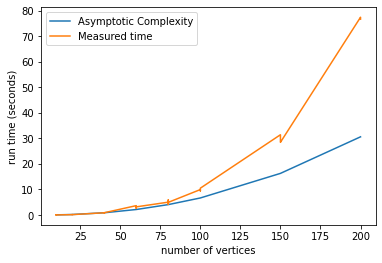

In [15]:
import matplotlib.pyplot as plt 
graph_sizes = [g.V for g in graphs]
reference = [1e-4*math.pow(n,2)*(math.log2(n)) for n in graph_sizes]
plt.plot(graph_sizes[:31],reference[:31])
plt.plot(graph_sizes[:31],execution_times)
plt.legend(['Asymptotic Complexity', 'Measured time'])
plt.ylabel('run time (seconds)')
plt.xlabel('number of vertices')
plt.show()


<h4>Plot of discovery iteration compared to number of iterations</h4>

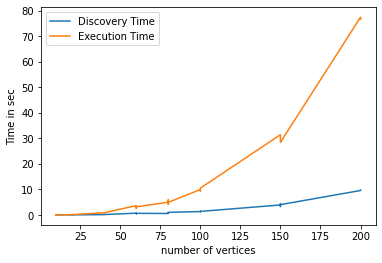

In [24]:
import matplotlib.pyplot as plt 
graph_sizes = [g.V for g in graphs]
plt.plot(graph_sizes[:31],discovery_times)
plt.plot(graph_sizes[:31],execution_times)
plt.legend(['Discovery Time', 'Execution Time'])
plt.ylabel('Time in sec')
plt.xlabel('number of vertices')
plt.show()


Average running time and Discovery time 

In [26]:
avg_exec = avg_discover = 0
for i in range(len(execution_times)):
    avg_exec += execution_times[i]
    avg_discover += discovery_times[i]
avg_exec /= len(execution_times)
avg_discover /= len(discovery_times)
print(avg_exec, avg_discover)    

13.757255784926876 1.7993300653273059
